# Talent Squad Hackaton 2022
___
## - Objetive:

The objective of the challenge will be to develop a predictive model that allows to know the type of eruption that a rocket will have depending on the vibrations measured by the sensors.

Once the predictive model has been made and trained, it will have to be used with the features of the testing dataset 'space_X_test.csv'. These predictions will have to be delivered in csv format as in the example. Where only one column will have to appear in which the first row is any text and the predictions start in row 2.

The quality of the prediction will be measured from the f1-score (macro)




___

In [2]:
#Import the libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import plot_confusion_matrix
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")


___

## Exploratory Analysis

In [3]:
#Import the DataSet:
df= pd.read_csv('space_X_train.csv', index_col=0)
df.head()

,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,target
0,0.474335,0.881640,-2.050543,-1.251935,-1.035151,-1.934367,4
1,-1.034675,1.741801,-1.660629,-1.555989,-0.337553,-2.473838,0
2,-0.563221,-0.688381,-0.318415,-1.845172,0.352366,-0.912928,1
3,-1.268179,2.770688,1.054193,2.830389,0.395093,0.677715,3
4,-1.216380,-0.391267,-2.898931,-0.913074,-2.171857,-2.367490,0


In [3]:
#Some statics from our Data Set:
df.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
sensor_1,2100.0,-0.20,1.54,-6.68,-1.17,-0.44,0.89,4.57
sensor_2,2100.0,0.20,1.61,-5.38,-0.88,0.32,1.32,6.70
sensor_3,2100.0,-0.38,1.45,-6.15,-1.37,-0.44,0.66,4.16
sensor_4,2100.0,-0.21,1.44,-5.65,-1.26,-0.18,0.87,4.37
sensor_5,2100.0,-0.19,1.50,-5.91,-1.21,-0.20,0.85,5.07
sensor_6,2100.0,-0.43,1.19,-4.43,-1.13,-0.41,0.35,4.02
target,2100.0,1.98,1.41,0.00,1.00,2.00,3.00,4.00


In [4]:
#Information and type of each column:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2100 entries, 0 to 2099
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   sensor_1  2100 non-null   float64
 1   sensor_2  2100 non-null   float64
 2   sensor_3  2100 non-null   float64
 3   sensor_4  2100 non-null   float64
 4   sensor_5  2100 non-null   float64
 5   sensor_6  2100 non-null   float64
 6   target    2100 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 131.2 KB


In [5]:
#Check the null values:
df.isnull().sum()

sensor_1    0
sensor_2    0
sensor_3    0
sensor_4    0
sensor_5    0
sensor_6    0
target      0
dtype: int64

In [61]:
#Counting the values for each class:
total_classes= df['target'].value_counts()
total_classes

0    427
3    426
1    423
2    419
4    405
Name: target, dtype: int64

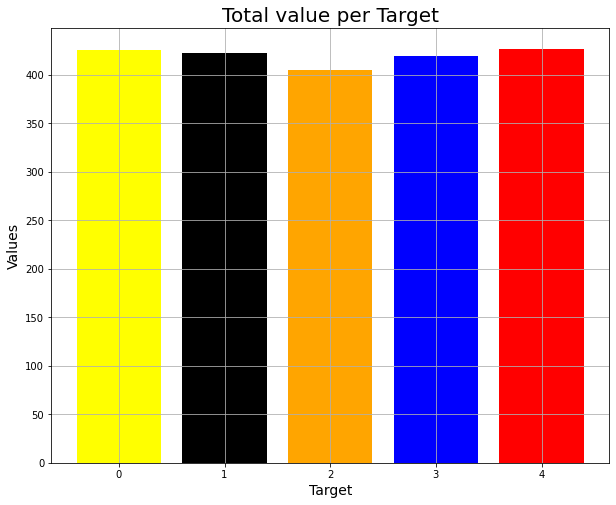

In [7]:
#Plot the total values of each target
fig = plt.figure(figsize=(10,8))

#Set colors of each bar
c = ['red', 'yellow', 'black', 'blue', 'orange']

plt.bar(df['target'].unique(), total_classes,label= "target",color=c)

plt.title("Total value per Target",fontsize=20)

plt.ylabel("Values", fontsize=14)
plt.xlabel("Target", fontsize=14)

plt.grid()
plt.show()

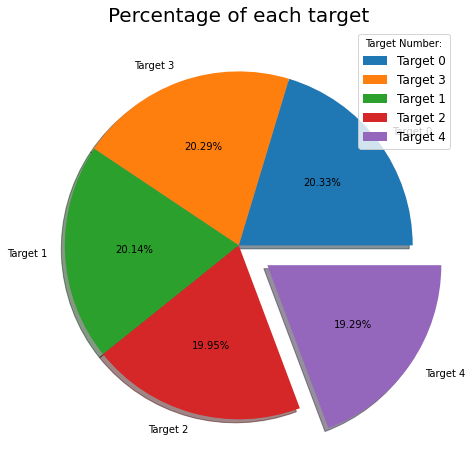

In [8]:
#Donut Chart with the total of each cluster.
plt.figure(figsize=(8,8))
labels = ["Target 0", "Target 3", "Target 1", "Target 2", "Target 4"]
explode = [0, 0 , 0, 0, 0.2]
plt.pie(total_classes, labels = labels, autopct='%.2f%%', explode=explode, shadow=True)

plt.title("Percentage of each target",fontsize=20)
plt.legend(title= "Target Number:", fontsize=12, loc="best")

plt.show()

As the graph shows us the classes are balanced, so it is very good that this happens to have a better prediction of our algorithm and that it is not biased.

___

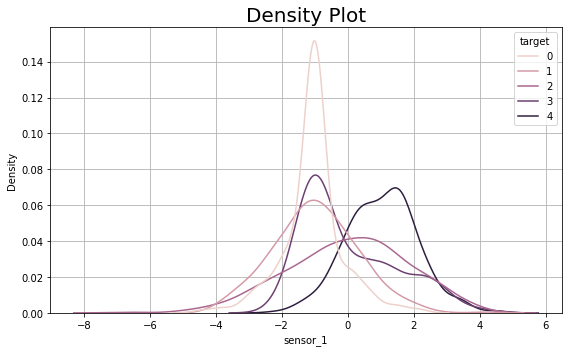

In [9]:
#Ploteamos un Grafico de Densidad para ver la distribucion de los datos de cada insecto respecto al tiempo de registro:
%matplotlib inline
fig = plt.figure(figsize=(8,5))
sns.kdeplot(data=df, x="sensor_1", hue="target")
plt.title("Density Plot",fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

This density plot shows the number of records that exist for each target with respect to sensor 1 and what values they occupy. While some of them follow a normal distribution, other targets such as 3 and 4 do not follow a normal distribution.

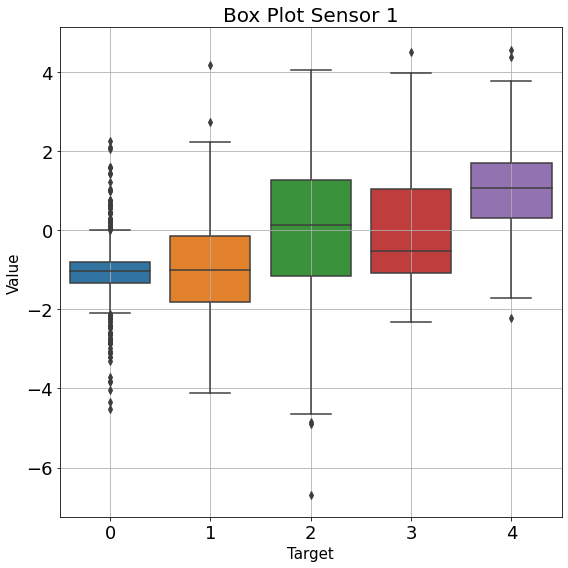

In [59]:
#Check the values of Sensor 1:
fig = plt.figure(figsize=(8,8))

#Boxplot
sns.boxplot(x=df.target, y=df.sensor_1) 

plt.title('Box Plot Sensor 1', fontsize=20)
plt.xlabel("Target",fontsize=15)
plt.ylabel("Value", fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



plt.tight_layout()
plt.grid()
plt.show()

We see here that we do not have so many outliers for targets 1,2,3 and 4 but we do for target 0. The boxplot allows us to easily see these values, as well as the quartiles that are the extremes of each box and the average that would be the line that divides each box and the outliers are plotted as points.

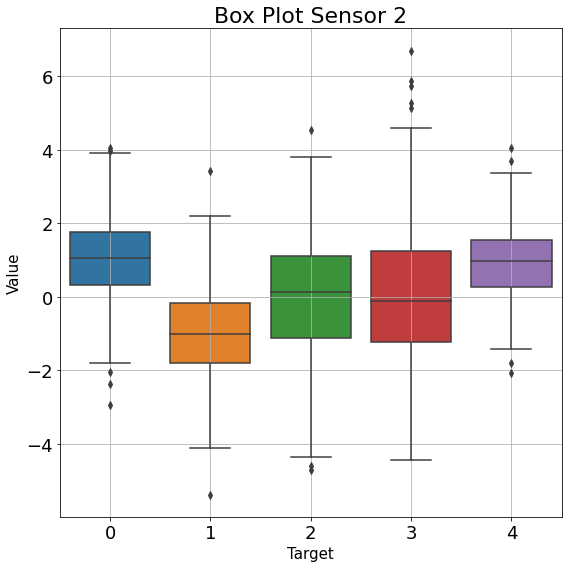

In [60]:
#Check the values of Sensor 2:


fig = plt.figure(figsize=(8,8))

#Boxplot
sns.boxplot(x=df.target, y=df.sensor_2) 

plt.title('Box Plot Sensor 2', fontsize=22)
plt.xlabel("Target",fontsize=15)
plt.ylabel("Value", fontsize=15)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)



plt.tight_layout()
plt.grid()
plt.show()

Regarding sensor 2 each target has some outliers as the box plot shows

In [12]:
#Veamos el shape de nuestro dataset:
df.shape

(2100, 7)

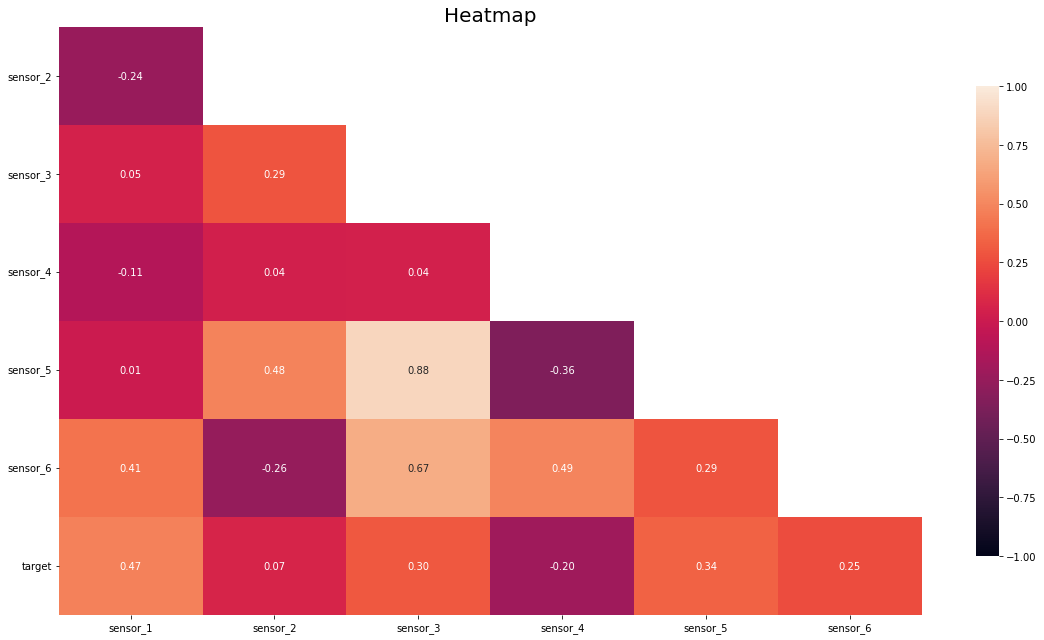

In [13]:
#Correlation:
corr = df.corr()

#Lets plot a HeatMap:
np.ones_like(corr, dtype=bool)
mask = np.triu(np.ones_like(corr, dtype=bool))
corr
fig, ax = plt.subplots(figsize=(16,9))# mask

mask = np.triu(np.ones_like(corr, dtype=bool))# adjust mask and df

mask = mask[1:, :-1]

corr = corr.iloc[1:,:-1].copy()# plot heatmap

sns.heatmap(corr, mask=mask, annot=True, fmt=".2f",
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})# yticks

plt.yticks(rotation=0)
plt.title("Heatmap",  fontsize=20)
plt.tight_layout()
plt.show()

This heat plot shows the correlation of our variables where the values can oscillate between -1 and 1, being positive correlation if it is greater than 0 or negative correlation if it is less than 0. Positive correlation means that when a value of our column increases, the columns with positive correlation on it will also increase, but if they have negative correlation when one value increases the other decreases.
In this case most of the sensors have a positive correlation while others do not have a significant correlation or rather the values are close to 0 which means that (there is no significant interrelation between them) or they have a negative correlation (when one increases the other decreases). In this way we can easily know which columns correlate more than others.

___

 ## Predictive Model
Once we cleared up the data with which we are going to work, checking the type of data of my columns, the verification of null values, correlation of variables, etc. We will now consider the problem we want to solve.
 As we are facing a classification problem, where we are going to train our algorithm with the Train dataset and then give as input the Test dataset to predict our target (turbulence type).
 In this case I will use the CatBoost Classifier algorithm. This model works very well because it is very fast to process data.

In [4]:
#Dividimos el Dataset en dos variables X e Y, y quitamos las columnas que no nos interesan.

X = df.drop(['target'], axis= 1)
y = df['target']

print(X.shape)
print(y.shape)

(2100, 6)
(2100,)


In [5]:
#Dividimos el dataset en dos Train and Test con la libreria de Sk learn para entrenar nuestro modelo y luego evaluarlo:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [6]:
#Create an object with our CatBoost Model

model = CatBoostClassifier(verbose=False)
model.fit(X_train, y_train)

#Lets predict some values:
model_pred =model.predict(X_test)

#Evaluate our Model
print("Accuracy:",metrics.accuracy_score(y_test, model_pred))
# Precision: 
precision_model = precision_score(model_pred, y_test, average='macro')
print('Precision:', precision_model)
# Recall: 
recall_model = recall_score(model_pred, y_test, average='macro')
print('Recall:', recall_model)
# f1 score
f1_model = f1_score(model_pred, y_test, average='macro')
print('F1:', f1_model)

Accuracy: 0.7928571428571428
Precision: 0.7932835356364768
Recall: 0.7934348797490044
F1: 0.7929906518786128


___
## CatBoost Classifier:

In [7]:
# Preprocedado
# ==============================================================================

# DataFrame with numeric columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Apply Robust Scaler to the numerical variables
numeric_transformer = Pipeline(
                        steps=[('scaler', RobustScaler())]
                      )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

# Combining the steps and create a Pipeline

pipe = Pipeline([('preprocessing', preprocessor),
                ('data_scaling',numeric_transformer),
                ('model',CatBoostClassifier(verbose=False))])

# Train
# ==============================================================================
# Fit the data
_ = pipe.fit(X=X_train, y=y_train)


#Predict the result:
pipe_pred = pipe.predict(X_test)

#Veamos las metricas de evaluación que obtuvimos:

print("Accuracy:",metrics.accuracy_score(y_test, pipe_pred))
# Precision: 
precision_pipe = precision_score(pipe_pred, y_test, average='macro')
print('Precision:', precision_pipe)
# Recall: 
recall_pipe = recall_score(pipe_pred, y_test, average='macro')
print('Recall:', recall_pipe)
# f1 score
f1_pipe = f1_score(pipe_pred, y_test, average='macro')
print('F1:', f1_pipe)

Accuracy: 0.7928571428571428
Precision: 0.7932835356364768
Recall: 0.7934348797490044
F1: 0.7929906518786128


In [8]:
#5 cross-validation scores:
pipe_cv = cross_val_score(pipe,X,y,cv=5, scoring='f1_macro',  error_score='raise', verbose=False ) 

#Show the values:
print(pipe_cv)
print("Average 5-Fold CV Score: {}".format(np.mean(pipe_cv)))
print('F1 First model:', f1_pipe)

[0.78513866 0.76972689 0.80199537 0.77829249 0.76724699]
Average 5-Fold CV Score: 0.7804800789486245
F1 First model: 0.7929906518786128


In [26]:
#Confusion Matrix:
cm_rf = confusion_matrix(y_test, pipe_pred)

print(cm_rf)

[[72  7  4  2  0]
 [ 5 64  4 11  1]
 [ 6  9 62  3  4]
 [ 2  3  6 66  8]
 [ 3  0  2  7 69]]


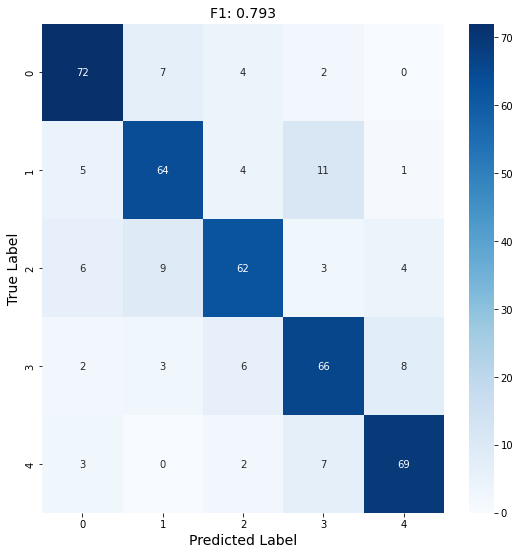

In [23]:
#Ploteamos la matriz de confusión:
plt.figure(figsize=(9,9))


ax = sns.heatmap(cm_rf, annot=True, fmt='', cmap='Blues')

title = 'F1: {0}'.format(f1_pipe.round(3))
ax.set_title(title, fontsize=14);


ax.set_xlabel('Predicted Label',fontsize=14)
ax.set_ylabel('True Label', fontsize=14);



##Mostramos la matriz.
plt.show()

Here we can see that the main diagonal shows the successes that the model had in classifying our target. While the other data correspond to what the algorithm predicted but was actually another type of turbulence.

___

### Once we have our model trained we proceed to pass the data from our Test.csv to see what results we get:

In [24]:
#Importamos el Test DataSet:
df_test = pd.read_csv('space_X_test.csv', index_col=0)
df_test.head()


,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6
0,0.943723,-2.985473,-0.938218,3.580261,-3.038106,2.080338
1,-0.899819,1.295568,1.274513,0.718186,1.117035,0.463068
2,0.293281,-0.099317,1.874902,-0.589582,1.828441,1.011596
3,-1.134804,0.888585,-1.464499,-1.183056,-0.525729,-1.963822
4,-0.909240,1.575797,0.697212,1.197092,0.486185,0.222644


In [25]:
df_test.shape

(900, 6)

Training our model with all the data to predict the results:

In [9]:
# Preprocessing
# ==============================================================================

# DataFrame with numeric columns
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()

# Apply Robust Scaler to the numerical variables
numeric_transformer = Pipeline(
                        steps=[('scaler', RobustScaler())]
                      )


preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols)
                    ],
                    remainder='passthrough'
                )

# Pipeline
# ==============================================================================

# Combining the steps and create a Pipeline

pipe = Pipeline([('preprocessing', preprocessor),
                ('data_scaling',numeric_transformer),
                ('model',CatBoostClassifier(verbose=False))])

# Train
# ==============================================================================
# Fit with all the data
_ = pipe.fit(X=X, y=y)


In [53]:
#Predict the result:
results = pipe.predict(df_test)


In [54]:
results = results.flatten()

In [55]:
#Create the Dataframe with the results:
results=pd.DataFrame({'Predicted Target':results})

In [56]:
 #Set the index to start at 2:
 results.index = np.arange(2, len(results)+2)
 results

,Predicted Target
2,1
3,3
4,2
5,0
6,3
...,...
897,3
898,4
899,0
900,3


In [57]:
# Save the DataFrame with the predictions:

results.to_csv('results.csv', header=True, index=True)


___
### Conlusion: 
Although different types of algorithms were tested such as, Random Forest Classifier,AdaBoostClassifier, KNeighbors Classifier, Logistic Regression, etc. The best F1 macro result was obtained with the CatBoost Classifier, with a result of 0.793.
 The result could be higher if we had more data to train our model, anyway I think the result was quite acceptable when predicting the type of turbulence.

___


Documentation:
- CatBoost Classifier: https://catboost.ai/en/docs/concepts/python-reference_catboostclassifier
- Cross Validation: https://scikit-learn.org/stable/modules/cross_validation.html